# Kaggle Telco Customer Churn - Local Notebook Code

I use the Kaggle Telco Customer Churn dataset and I predict **Churn** as a binary classification task.

## What I do
- Load the CSV locally
- Audit columns, types, missing values, and target distribution
- Clean the dataset
  - remove irrelevant ID column
  - convert `TotalCharges` to numeric
  - handle missing values
  - remove duplicates
- Build a preprocessing pipeline
  - scale numeric features
  - one-hot encode categorical features
- Train multiple classifiers
- Compare model performance using
  - test-set accuracy
  - cross-validated accuracy
- Plot bar charts for accuracy comparisons


In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score


## 1) Load the dataset

I set `CSV_PATH` to the local path where the Kaggle CSV is stored.


In [44]:
CSV_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(CSV_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Initial audit

I inspect the dataset shape, column names, data types, missing values, and the distribution of the target column.


In [45]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\nTarget distribution (Churn):")
print(df["Churn"].value_counts(dropna=False))


Shape: (7043, 21)

Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Dtypes:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing values per column:
custome

## 3) Cleaning

I clean the dataset by:
- removing `customerID`
- converting `TotalCharges` into numeric values
- removing duplicates
- imputing missing values using median for numeric and mode for categorical
- visualizing correlations between numeric features to spot redundancy


### Step 1

I start by making a clean working copy, dropping the identifier column, converting `TotalCharges` to numeric, and removing duplicates.  
After converting `TotalCharges`, blank or invalid values become missing values, so I print missing-value counts to see what needs imputation.


In [46]:
df_clean = df.copy()

if "customerID" in df_clean.columns:
    df_clean = df_clean.drop(columns=["customerID"])

df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

df_clean = df_clean.drop_duplicates()

print("Shape after dropping ID and duplicates:", df_clean.shape)
print("\nMissing values after TotalCharges conversion:")
print(df_clean.isna().sum().sort_values(ascending=False).head(20))


Shape after dropping ID and duplicates: (7021, 20)

Missing values after TotalCharges conversion:
TotalCharges        11
gender               0
Partner              0
SeniorCitizen        0
Dependents           0
tenure               0
MultipleLines        0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
InternetService      0
TechSupport          0
StreamingTV          0
Contract             0
StreamingMovies      0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
Churn                0
dtype: int64


### Step 2

I identify numeric and categorical columns and handle missing values using simple rules:
- numeric columns use the median
- categorical columns use the most frequent value

In this dataset, most columns are already complete.  
The main place missing values can appear is `TotalCharges` after converting it to numeric, because blanks are coerced into missing values.

Even though I split features and target later, I still exclude `Churn` here so it never gets modified during cleaning.  
I print missing-value counts again to confirm the dataset is usable for modeling.



In [47]:
target_col = "Churn"

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()

if target_col in numeric_cols:
    numeric_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

missing_counts = df_clean.isna().sum()
num_missing_cols = [c for c in numeric_cols if missing_counts[c] > 0]
cat_missing_cols = [c for c in categorical_cols if missing_counts[c] > 0]

for c in num_missing_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in cat_missing_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].mode(dropna=True)[0])

print("Remaining missing values:")
print(df_clean.isna().sum().sort_values(ascending=False).head(20))

df_clean.head()



Remaining missing values:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Correlation heatmap

I compute a correlation matrix for numeric features and plot it as a heatmap.  
This helps me spot strongly related numeric features that may be redundant.


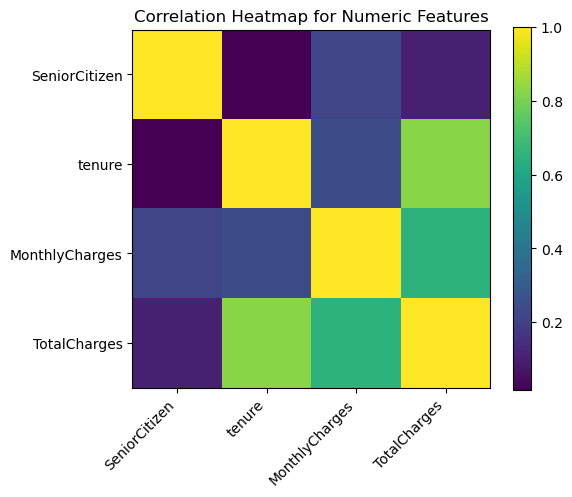

In [48]:
import matplotlib.pyplot as plt

corr = df_clean[numeric_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap for Numeric Features")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.tight_layout()
plt.show()


### Other columns I could remove

I remove columns when they are irrelevant, redundant, or uninformative.

- `customerID` is always safe to remove because it is an identifier.
- `TotalCharges` and `tenure` can be redundant because TotalCharges is strongly related to tenure and MonthlyCharges.  
  If the heatmap shows a very strong correlation, I can drop either `TotalCharges` or `tenure` to reduce redundancy.
- Columns with near-zero variance do not help prediction because they barely change across customers.
- Any column that becomes constant after cleaning can be removed.

I keep this step explicit so I can easily test performance with and without the removed column.


In [49]:

# df_clean = df_clean.drop(columns=["TotalCharges"])
# numeric_cols = [c for c in numeric_cols if c != "TotalCharges"]

df_clean.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 4) Create X and y and split the data

I separate features and target, encode the target as 0 and 1, and split into train and test sets with stratification.


In [50]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].map({"No": 0, "Yes": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())


Train shape: (5616, 19) Test shape: (1405, 19)
Train churn rate: 0.2644230769230769 Test churn rate: 0.26476868327402137


## 5) Preprocessing pipeline

I preprocess numeric and categorical features using a `ColumnTransformer`.
Numeric features get imputed and scaled, and categorical features get imputed and one-hot encoded.


In [51]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
    remainder="drop"
)


## 6) Define classifiers

I train a set of common classifiers for comparison.


In [52]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "SVM_RBF": SVC(kernel="rbf"),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "GaussianNB": GaussianNB(),
}


## 7) Test-set evaluation with plotted confusion matrices

I train each model on the training split, evaluate it on the test split, and collect test accuracy for comparison.  
For each model, I print the classification report and I plot the confusion matrix so I can see false positives and false negatives visually.



=== LogisticRegression ===
Test accuracy: 0.8028
              precision    recall  f1-score   support

           0     0.8405    0.9032    0.8707      1033
           1     0.6610    0.5242    0.5847       372

    accuracy                         0.8028      1405
   macro avg     0.7508    0.7137    0.7277      1405
weighted avg     0.7930    0.8028    0.7950      1405



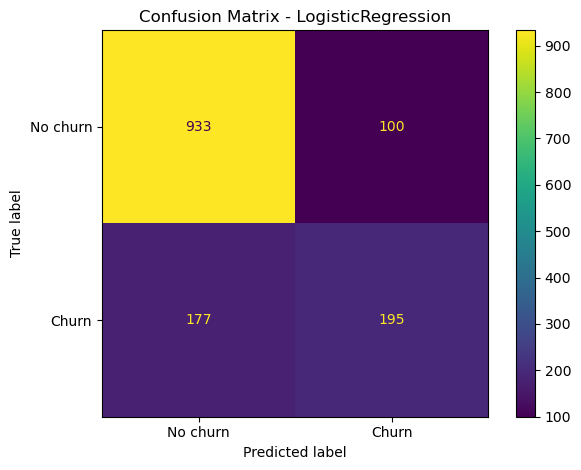


=== SVM_RBF ===
Test accuracy: 0.7986
              precision    recall  f1-score   support

           0     0.8313    0.9109    0.8693      1033
           1     0.6630    0.4866    0.5612       372

    accuracy                         0.7986      1405
   macro avg     0.7471    0.6987    0.7153      1405
weighted avg     0.7867    0.7986    0.7877      1405



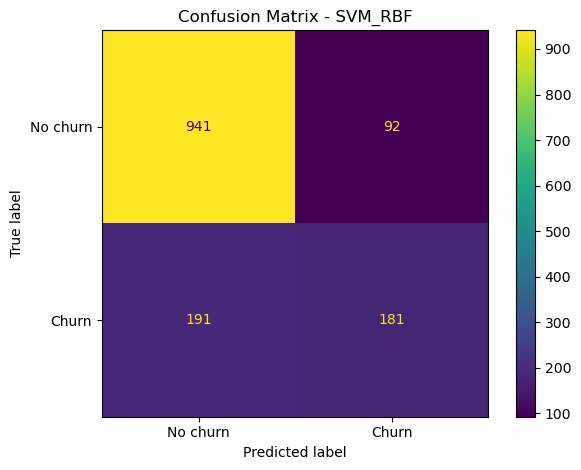


=== DecisionTree ===
Test accuracy: 0.7936
              precision    recall  f1-score   support

           0     0.8344    0.8974    0.8647      1033
           1     0.6395    0.5054    0.5646       372

    accuracy                         0.7936      1405
   macro avg     0.7369    0.7014    0.7147      1405
weighted avg     0.7828    0.7936    0.7853      1405



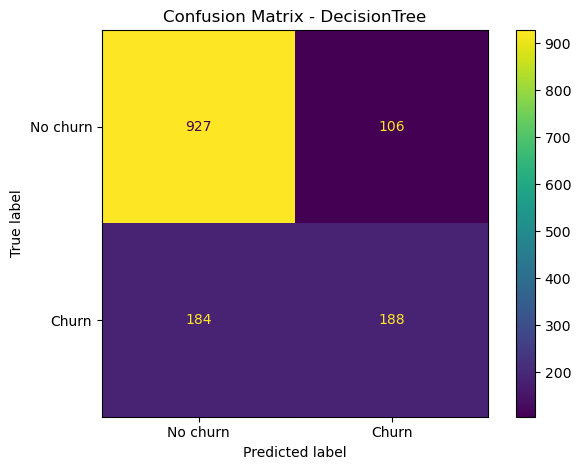


=== RandomForest ===
Test accuracy: 0.7786
              precision    recall  f1-score   support

           0     0.8189    0.8974    0.8564      1033
           1     0.6117    0.4489    0.5178       372

    accuracy                         0.7786      1405
   macro avg     0.7153    0.6732    0.6871      1405
weighted avg     0.7640    0.7786    0.7667      1405



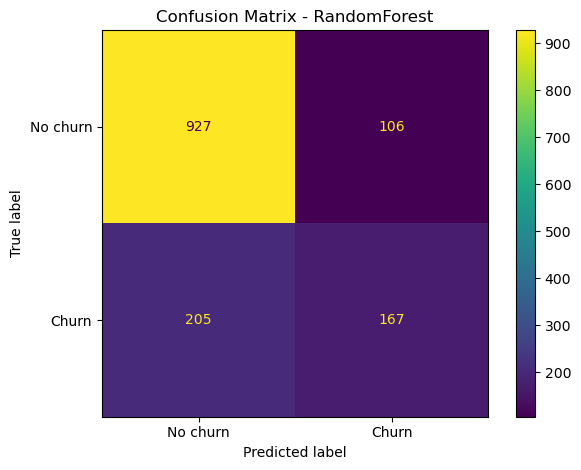


=== KNN ===
Test accuracy: 0.7851
              precision    recall  f1-score   support

           0     0.8406    0.8732    0.8566      1033
           1     0.6054    0.5403    0.5710       372

    accuracy                         0.7851      1405
   macro avg     0.7230    0.7068    0.7138      1405
weighted avg     0.7784    0.7851    0.7810      1405



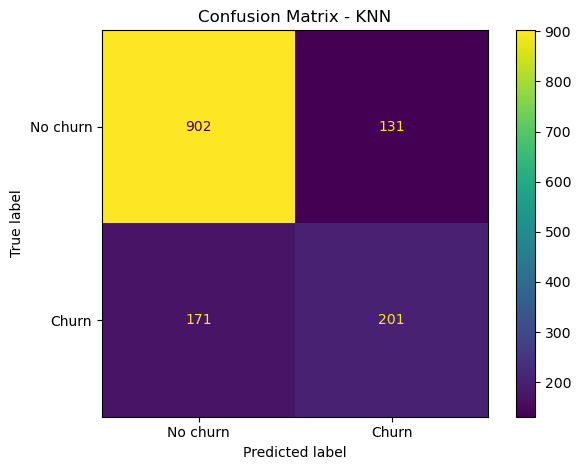


=== GaussianNB ===
Test accuracy: 0.6861
              precision    recall  f1-score   support

           0     0.9146    0.6321    0.7476      1033
           1     0.4501    0.8360    0.5851       372

    accuracy                         0.6861      1405
   macro avg     0.6823    0.7341    0.6664      1405
weighted avg     0.7916    0.6861    0.7046      1405



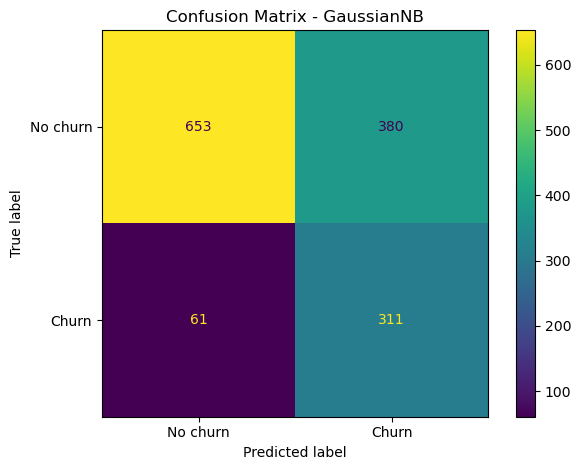

,Model,Test Accuracy
0,LogisticRegression,0.802847
1,SVM_RBF,0.798577
2,DecisionTree,0.793594
3,KNN,0.785053
4,RandomForest,0.778648
5,GaussianNB,0.686121


In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

test_rows = []

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    test_rows.append((name, acc))

    print(f"\n=== {name} ===")
    print(f"Test accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, digits=4))

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No churn", "Churn"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

test_df = (
    pd.DataFrame(test_rows, columns=["Model", "Test Accuracy"])
      .sort_values("Test Accuracy", ascending=False)
      .reset_index(drop=True)
)

test_df


## 8) Bar chart of test accuracy

I plot test accuracy to compare model performance on the same train/test split.


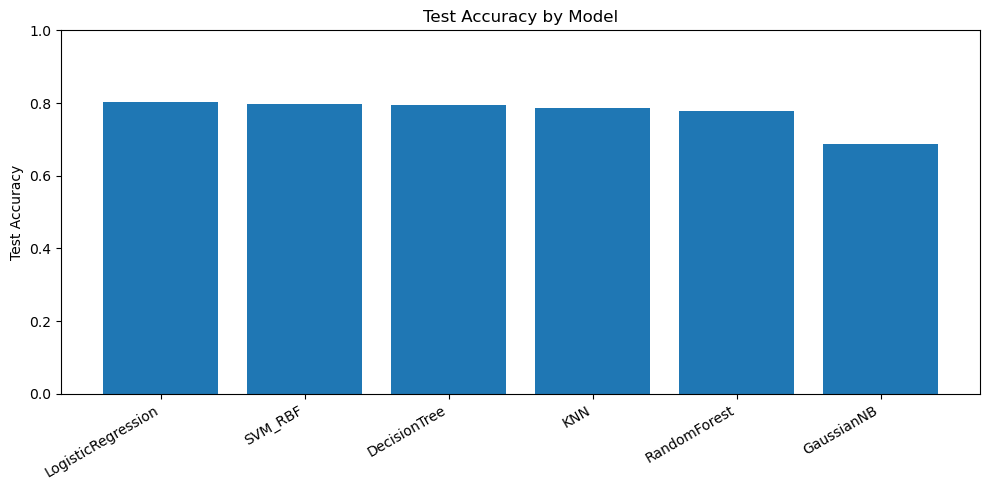

In [54]:
plt.figure(figsize=(10, 5))
plt.bar(test_df["Model"], test_df["Test Accuracy"])
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy by Model")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 9) Cross-validated accuracy comparison

I use stratified 5-fold cross-validation to compare models using accuracy.
I compute mean and standard deviation across folds for each model.


In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", clf)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    cv_rows.append((name, scores.mean(), scores.std()))

cv_df = (
    pd.DataFrame(cv_rows, columns=["Model", "CV Acc mean", "CV Acc std"])
      .sort_values("CV Acc mean", ascending=False)
      .reset_index(drop=True)
)

cv_df


,Model,CV Acc mean,CV Acc std
0,LogisticRegression,0.803018,0.008041
1,SVM_RBF,0.799030,0.007530
2,DecisionTree,0.788347,0.010308
3,RandomForest,0.787920,0.009740
4,KNN,0.787207,0.011143
5,GaussianNB,0.693064,0.018619


## 10) Bar chart of cross-validated accuracy

I plot mean cross-validated accuracy for each model, with error bars showing standard deviation across folds.


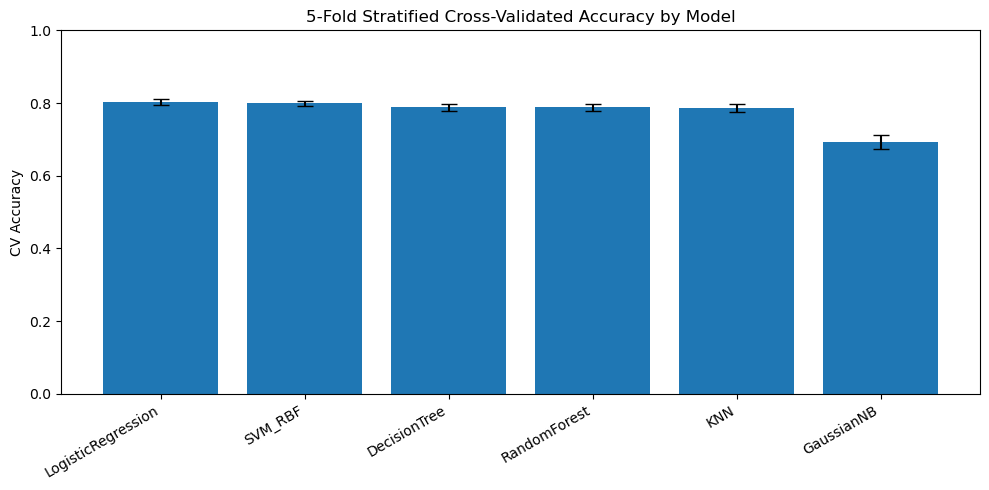

In [56]:
plt.figure(figsize=(10, 5))
plt.bar(cv_df["Model"], cv_df["CV Acc mean"], yerr=cv_df["CV Acc std"], capsize=6)
plt.ylabel("CV Accuracy")
plt.title("5-Fold Stratified Cross-Validated Accuracy by Model")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## Report notes

### Cleaning summary
- I removed `customerID` because it is an identifier
- I converted `TotalCharges` to numeric and treated blanks as missing values
- I removed duplicates
- I imputed missing values using median for numeric columns and mode for categorical columns

### Modeling summary
- I used a preprocessing pipeline to scale numeric features and one-hot encode categorical features
- I compared multiple classifiers on test accuracy and cross-validated accuracy
- I inspected confusion matrices and classification reports to understand error patterns
